In [1]:
#! /usr/bin/env python
# general
import os
from os.path import join
import sys
from pathlib import Path
import math
import copy
import time

# ml
import torch
import torch.backends.cudnn as cudnn

# Plot
from matplotlib import pyplot as plt
import numpy as np

# cv
import cv2
import scipy.ndimage as ndimage
# from cv_bridge import CvBridge, CvBridgeError

# yolov5 imports
from models.common import DetectMultiBackend
from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, time_sync


# ggcnnv2 imports
from ggcnn.models import ggcnn2
from ggcnn.utils.dataset_processing import grasp, image, evaluation1
from ggcnn.utils.dataset_processing.grasp import GraspRectangle
from ggcnn.models.common import post_process_output
from ggcnn.utils.timeit import TimeIt

topicmanager initialized


In [10]:
ROOT = '/home/felipe/code/APC/grasping/'
###################################################################################################
# YOLOV5
###################################################################################################
weights=ROOT+'content/datasets/cornell_v2/config/best.pt' # model.pt path(s)
data=ROOT+'content/datasets/cornell_v2/config/data.yaml'  # dataset.yaml path
source=ROOT+'content/datasets/cornell_v2/test/images/pcd0852r_png.rf.4f2aa5133b5b49e692fa54b351d74d9e.jpg'
imgsz=(480, 640)  # inference size (height, width)
conf_thres=0.25  # confidence threshold
iou_thres=0.45  # NMS IOU threshold
max_det=10  # maximum detections per image
device=''  # cuda device, i.e. 0 or 0,1,2,3 or cpu
view_img=True  # show results
save_txt=True  # save results to *.txt
save_conf=True  # save confidences in --save-txt labels
save_crop=True  # save cropped prediction boxes
nosave=False  # do not save images/videos
classes=None  # filter by class: --class 0, or --class 0 2 3
agnostic_nms=False  # class-agnostic NMS
augment=False  # augmented inference
visualize=False  # visualize features
update=False  # update all models
project=ROOT+'runs/detect'  # save results to project/name
name='exp'  # save results to project/name
exist_ok=False  # existing project/name ok, do not increment
line_thickness=3  # bounding box thickness (pixels)
hide_labels=False  # hide labels
hide_conf=False  # hide confidences
half=False  # use FP16 half-precision inference
dnn=False  # use OpenCV DNN for ONNX inference

# CUDA or CPU
device = select_device(device)
# yolov5 NN
model = DetectMultiBackend(weights, device=device, data=data)
# model features
stride, names, pt = model.stride, model.names, model.pt
# image  size  check
imgsz = check_img_size(imgsz, s=stride) 

# yolo can can manage video stream, multiple images, etc. So all source data is loaded as a dataset
dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
bs = 1 

# model warmup to inform the input size
model.warmup(imgsz=(1 if pt else bs, 3, *imgsz)) 

# get the image from the dataset
for path, im, im0s, vid_cap, s in dataset:
    im = im

# Load the image using cv2 did not work
# im = cv2.imread(source)
# im = im.reshape((3,480,640))

# image processing - nparray - normalization - reshape to (1, 3, h, w)
im = torch.from_numpy(im).to(device)
im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
im /= 255  # 0 - 255 to 0.0 - 1.0
if len(im.shape) == 3:
    im = im[None]

# model prediction
pred = model(im, augment=augment, visualize=visualize)
pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

# extract the info from the pred
roi = pred[0].cpu().detach().numpy()[0,:4].astype(int) # [x0 y0 x1 y1]
print(roi)

YOLOv5 🚀 8e7e91a torch 1.11.0+cu102 CUDA:0 (Quadro P4000, 8116MiB)

Fusing layers... 
Model Summary: 213 layers, 7077550 parameters, 0 gradients


[217 190 367 315]


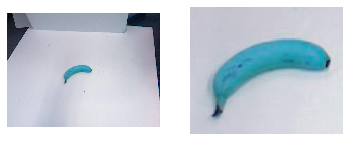

In [11]:
plt.subplot(1,2,1)
plt.imshow(cv2.imread(source))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(cv2.imread(source)[roi[1]:roi[3], roi[0]:roi[2]])
plt.axis('off')
plt.show()

/home/felipe/.local/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/felipe/.local/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/felipe/.local/lib/python3.8/site-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object

480 640


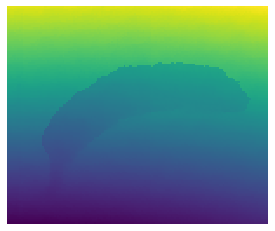

In [3]:
###################################################################################################
# GGCNN
###################################################################################################
device2 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
crop_size = 300
out_size = crop_size
y_off = 0
x_off = 0
MODEL_FILE = 'ggcnn/ggcnn2_093'
model2 = torch.load(MODEL_FILE, map_location=device2)

# Carga la imagen RGB -> El metodo ya esta definido en utils.dataset_processing import image
rgb_img = image.Image.from_file('/home/felipe/code/APC/ggcnn/datasets/cornell/08/pcd0852r.png')

# Carga la imagen de profundidad -> El metodo ya esta definido en utils.dataset_processing import image DepthImage
# Se puede cargar desde el tiff
depth_img = image.DepthImage.from_tiff('/home/felipe/code/APC/ggcnn/datasets/cornell/08/pcd0852d.tiff')
# Se puede cargar desde el pcd
depth_img_pcd = image.DepthImage.from_pcd('/home/felipe/code/APC/ggcnn/datasets/cornell/08/pcd0801.txt',depth_img.__getattr__('shape'))

# La funcion de __getattr__ permite traer propiedades del objeto imagen
imh, imw = depth_img.__getattr__('shape')
print(imh, imw)

# depth_crop tiene que ser un array 
depth_crop = np.asarray(depth_img)
depth_crop2 = np.asarray(depth_img)
# The ROI region is crop to the depth image
depth_crop = depth_crop[roi[1]:roi[3], roi[0]:roi[2]]
%matplotlib inline
plt.imshow(depth_crop)
plt.axis('off')
plt.show()

In [4]:
# Agrega un borde de un pixel a la imagen - para aplicar filtros
# Crea una mascara verificando si hay nan (en general dara ceros)
with TimeIt('1'):
    depth_crop = cv2.copyMakeBorder(depth_crop, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
    depth_nan_mask = np.isnan(depth_crop).astype(np.uint8)
depth_crop[0,0]
print(depth_crop.shape)
print(depth_nan_mask.shape)
# Si encuentra algun valor que sea nan lo vuelve cero 
with TimeIt('2'):
    depth_crop[depth_nan_mask==1] = 0
# Normalizacion
with TimeIt('3'):
    # Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
    depth_scale = np.abs(depth_crop).max()
    depth_crop = depth_crop.astype(np.float32) / depth_scale 
# Elimina trazos u otras imperfecciones
# with TimeIt('Inpainting'):
    # depth_crop = cv2.inpaint(depth_crop, depth_nan_mask, 1, cv2.INPAINT_NS)
# Restaura dimensiones y valores
depth_crop = depth_crop[1:-1, 1:-1] # quita el borde de 1 pixel
depth_crop = depth_crop * depth_scale
# Normaliza valores con el promedio en el rango [-1 1]
depth = depth_crop
depth = np.clip((depth - depth.mean()), -1, 1)
depthn = depth.copy()
# Convierte la imagen de profundidad a un tensor para usar en torch
depthT = torch.from_numpy(depth.reshape(1, 1, depth.shape[0], depth.shape[1]).astype(np.float32)).to(device)


1: 0.3ms
(127, 152)
(127, 152)
2: 7.5ms
3: 0.1ms


/tmp/ipykernel_4108/541446558.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  points_out = ndimage.filters.gaussian_filter(points_out, filters[0])  # 3.0
/tmp/ipykernel_4108/541446558.py:14: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  ang_out = ndimage.filters.gaussian_filter(ang_out, filters[1])
/tmp/ipykernel_4108/541446558.py:15: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  width_out = ndimage.filters.gaussian_filter(width_out, filters[2])


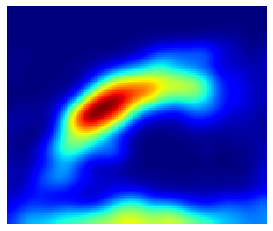

In [5]:
# no_grad se utiliza para validaciones, acelera calculos y reduce memoria
with torch.no_grad():
    # Se realiza la prediccion de la red
    pred_out = model2(depthT)
# Convierte el tensor de pythorch a un array de np, eliminando los ejes 1,1
points_out = pred_out[0].cpu().numpy().squeeze()
cos_out = pred_out[1].cpu().numpy().squeeze()
sin_out = pred_out[2].cpu().numpy().squeeze()
ang_out = np.arctan2(sin_out, cos_out) / 2.0

width_out = pred_out[3].cpu().numpy().squeeze() * 70.0  # Scaled 0-150:0-1
filters=(5.0, 4.0, 2.0)
points_out = ndimage.filters.gaussian_filter(points_out, filters[0])  # 3.0
ang_out = ndimage.filters.gaussian_filter(ang_out, filters[1])
width_out = ndimage.filters.gaussian_filter(width_out, filters[2])
points_out = np.clip(points_out, 0.0, 1.0-1e-3)
%matplotlib inline
plt.imshow(points_out,cmap='jet')
plt.axis('off')
plt.show()

In [6]:
grasps = grasp.detect_grasps(points_out, ang_out, 0.5, width_img=width_out, no_grasps=5)
# maxgrasps = evaluation1.plot_output(width_out, depth, points_out, ang_out, grasps, depth_crop2, crop_size, y_off, x_off)
grasps_info = evaluation1.grasp_info(width_out, points_out, ang_out, grasps)
grasps_info[0]

len 1
localn [[         58          53]]


/home/felipe/code/APC/grasping/ggcnn/utils/dataset_processing/grasp.py:428: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  is_peak = peak_local_max(q_img, min_distance=15, threshold_abs=threshold, indices=False)


{'q': 0.65826815,
 'pix': [58, 53],
 'ang': -36.29094998496088,
 'width': 22.946718}

In [7]:
def draw_angled_rec(x0, y0, width, height, angle, color, img):
    _angle = angle * math.pi / 180.0
    b = math.cos(_angle) * 0.5
    a = math.sin(_angle) * 0.5
    pt0 = (int(x0 - a * height - b * width),
           int(y0 + b * height - a * width))
    pt1 = (int(x0 + a * height - b * width),
           int(y0 - b * height - a * width))
    pt2 = (int(2 * x0 - pt0[0]), int(2 * y0 - pt0[1]))
    pt3 = (int(2 * x0 - pt1[0]), int(2 * y0 - pt1[1]))

    cv2.line(img, pt0, pt1, (), 1)
    cv2.line(img, pt1, pt2, color, 1)
    cv2.line(img, pt2, pt3, color, 1)
    cv2.line(img, pt3, pt0, color, 1)
    plt.imshow(img)
    plt.show()

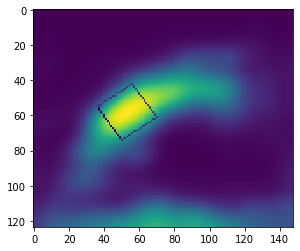

In [8]:
%matplotlib inline
test = points_out.copy()
draw_angled_rec(grasps_info[0]['pix'][1],grasps_info[0]['pix'][0],grasps_info[0]['width'],grasps_info[0]['width'],grasps_info[0]['ang'],(0.1,0.1,0),test)